In [25]:
import sys
sys.path.append('../')
import pdb
import pycm
from glob import glob
import torch
from torch import nn
import cv2
import os
from PIL import Image
from skimage import io, transform
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib.image as mpimg
import pandas as pd
from torchvision.datasets.folder import pil_loader
import random
import numpy as np
from torchsummary import summary
import pretrainedmodels
from sklearn.model_selection import KFold, StratifiedKFold
from tensorboard_logger import * 
from dataloader import *
from submission import *
from albumentations import torch as AT
from pycm import *
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix
os.environ['CUDA_VISIBLE_DEVICES']=""
%matplotlib inline

In [12]:
train_preds = pd.read_csv('../weights/6-7_resnext101_32x4d_fold1/ckpt30_train.csv')
train_actual = pd.read_csv('../data/train.csv')

In [32]:
df = train_preds.copy()
df['pred'] = train_preds['diagnosis']
df['actual'] = train_actual['diagnosis']
df = df.drop('diagnosis', axis=1)

In [33]:
df.head()

,id_code,pred,actual
0,000c1434d8d7,2,2
1,001639a390f0,4,4
2,0024cdab0c1e,0,1
3,002c21358ce6,0,0
4,005b95c28852,0,0


In [34]:
cm = ConfusionMatrix(df.actual.values, df.pred.values)

In [35]:
cm.print_matrix()

Predict    0          1          2          3          4          
Actual
0          1804       1          0          0          0          

1          247        12         105        0          6          

2          193        13         670        0          123        

3          12         1          93         0          87         

4          45         4          121        0          125        




In [36]:
cm.print_normalized_matrix()

Predict       0             1             2             3             4             
Actual
0             0.99945       0.00055       0.0           0.0           0.0           

1             0.66757       0.03243       0.28378       0.0           0.01622       

2             0.19319       0.01301       0.67067       0.0           0.12312       

3             0.06218       0.00518       0.48187       0.0           0.45078       

4             0.15254       0.01356       0.41017       0.0           0.42373       




### Inferences
Model is overfitting to 0 as a lot of predictions for class 1, 2 and 4 are being predicted as 0

It's completely unable to predict correctly for class 1, going for 0 and 2

It's is at somewhat better position when it comes to predicting 2

It never predicts 3, ffs! all of them are either classified as 2 or 4 :O

It it kinda average when it comes to predicting for 4, half the predictions go for  2

Model is extremely biased towards 0, followed by 2


In [24]:
cm.matrix

{0: {0: 1804, 1: 1, 2: 0, 3: 0, 4: 0},
 1: {0: 247, 1: 12, 2: 105, 3: 0, 4: 6},
 2: {0: 193, 1: 13, 2: 670, 3: 0, 4: 123},
 3: {0: 12, 1: 1, 2: 93, 3: 0, 4: 87},
 4: {0: 45, 1: 4, 2: 121, 3: 0, 4: 125}}

In [39]:
cm.TP, cm.FP, cm.TN, cm.FN

({0: 1804, 1: 12, 2: 670, 3: 0, 4: 125},
 {0: 497, 1: 19, 2: 319, 3: 0, 4: 216},
 {0: 1360, 1: 3273, 2: 2344, 3: 3469, 4: 3151},
 {0: 1, 1: 358, 2: 329, 3: 193, 4: 170})

In [41]:
diff = df[df['actual'] != df['pred']]

In [44]:
df.shape, diff.shape

((3662, 3), (1051, 3))

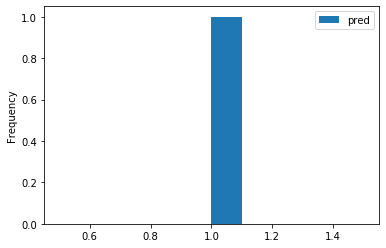

In [55]:
diff[diff['actual']==0][['pred']].plot(kind='hist');

There's only one mis-prediction for class 0, the model has ~ 1.0 sensitivity but very low precision (as can be interpreted from other charts) for 0 

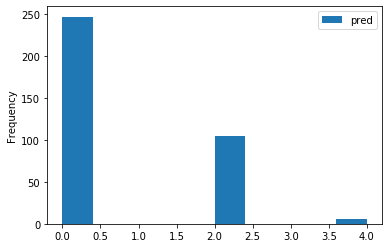

In [56]:
diff[diff['actual']==1][['pred']].plot(kind='hist');

When model misses to detect class 1, it goes for mostly 0 followed by 2

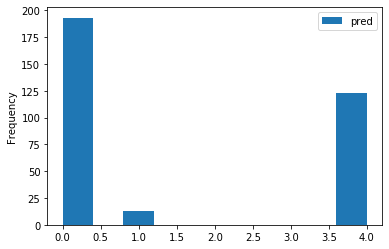

In [57]:
diff[diff['actual']==2][['pred']].plot(kind='hist');

Mispredictions of class 2 go to 0 and 4

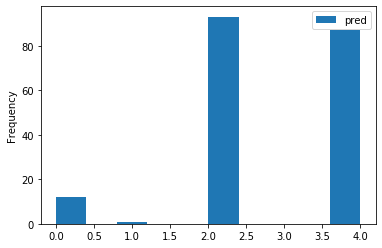

In [58]:
diff[diff['actual']==3][['pred']].plot(kind='hist');

Mispredictions of class 3 go to 2 and 4 equally

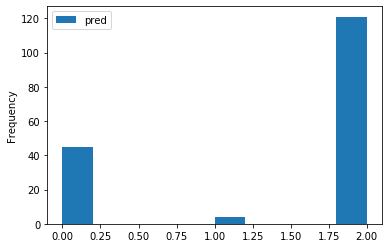

In [59]:
diff[diff['actual']==4][['pred']].plot(kind='hist');

Mispredictions of class 4 go to class 2 followed by 0

#### Inferences:

Class 0 --> always correctly predicted (High sensitivity, low precision)

Class 1 --> 0 and 2

Class 2 --> 0 and 4

Class 3 --> 2 and 4

Class 4 --> 2 and 0

### Let's plot some mispredictions

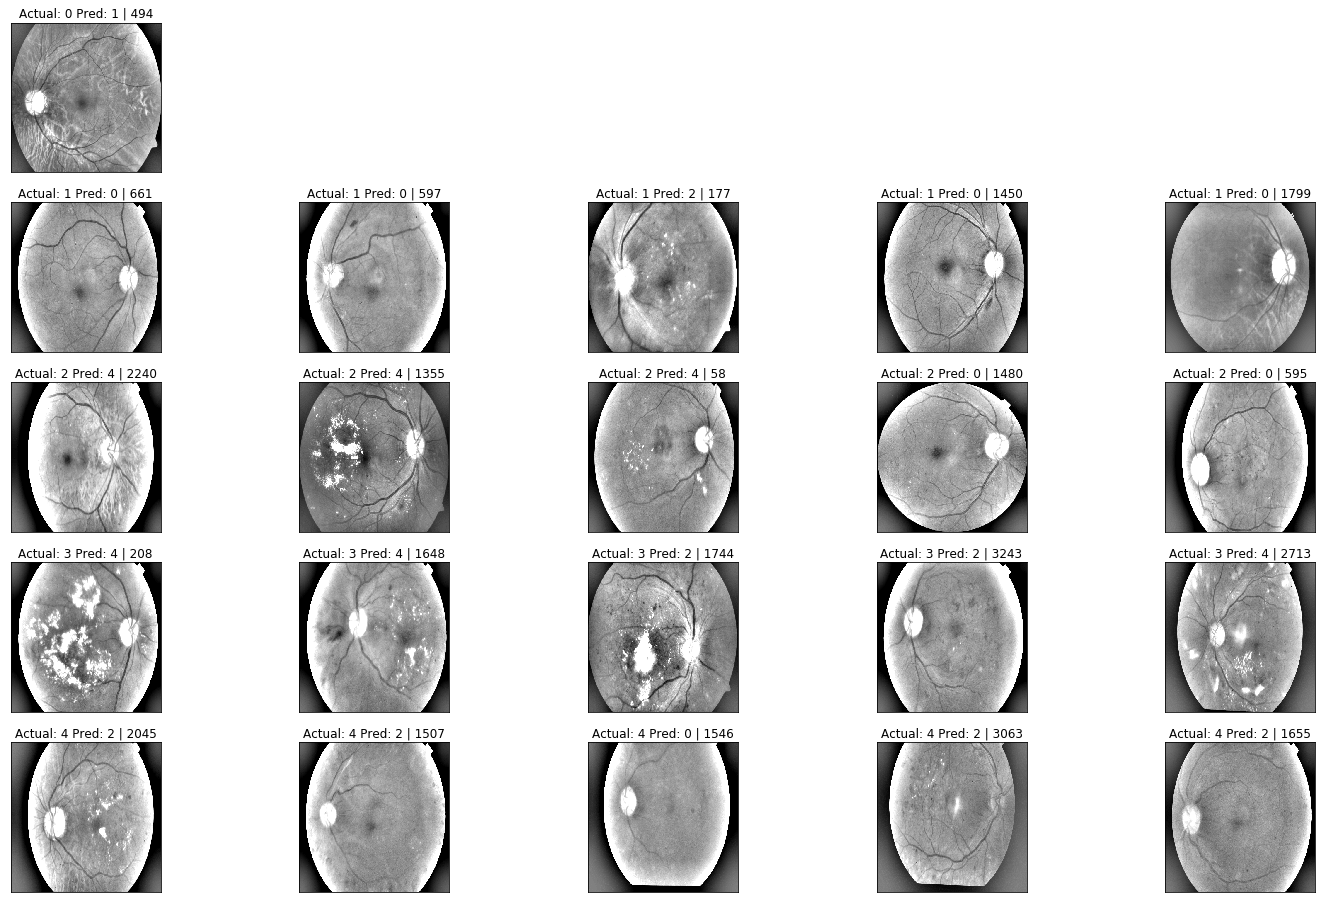

In [68]:
fig = plt.figure(figsize=(25, 16))
IMG_SIZE=512
for class_id in sorted(diff['actual'].unique()):
    samples = len(diff[diff['actual'] == class_id])
    samples = 5 if samples > 5 else samples # make sure there are atleast 5 predictions to plot or go for whatever is available
    for i, (idx, row) in enumerate(diff.loc[diff['actual'] == class_id].sample(samples, random_state=69).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../data/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line
        plt.imshow(image, cmap='gray')
        ax.set_title('Actual: %d Pred: %d | %s' % (class_id, row['pred'], idx) )

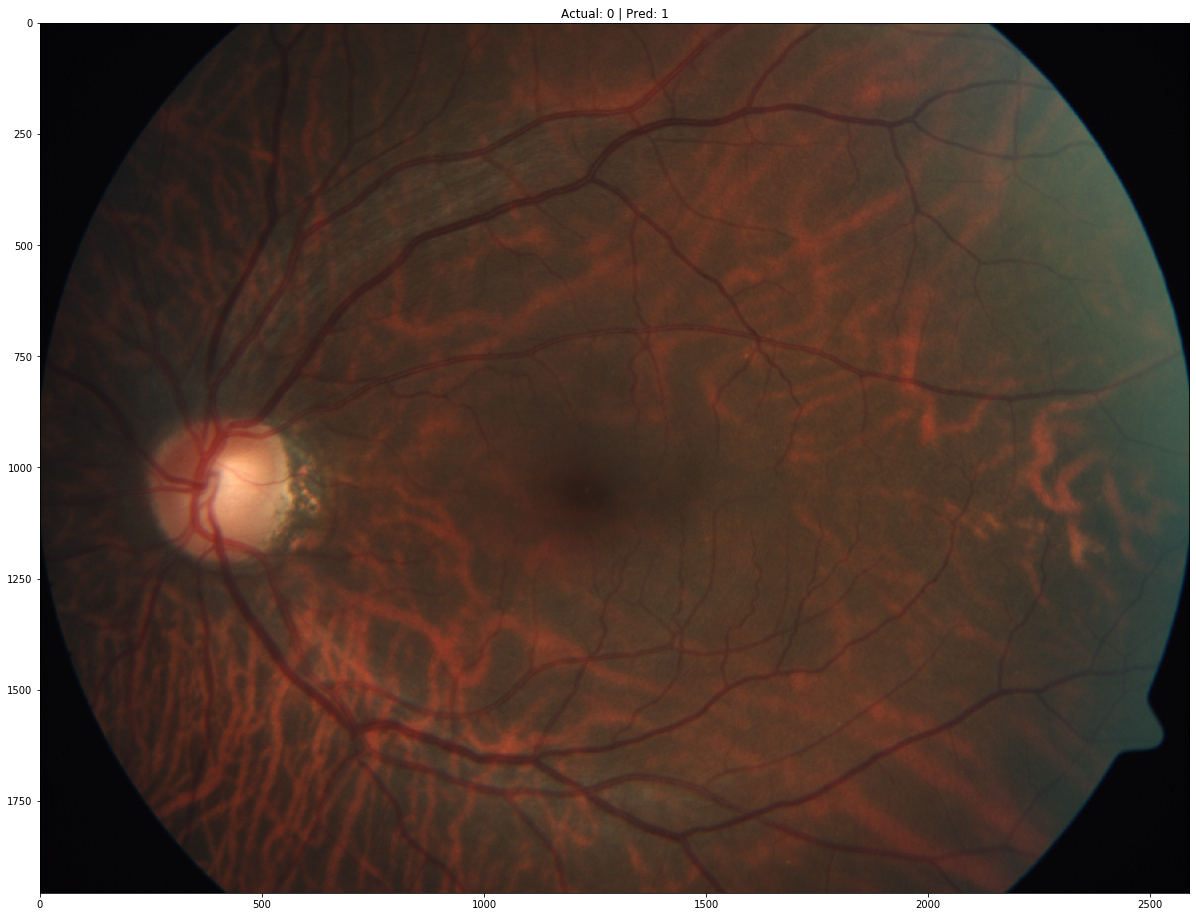

In [86]:
#i = 1546 
i = 494
#img = mpimg.imread() # remember the indices of diff are same as df
path = '../data/train_images/' + df.iloc[i]['id_code'] + '.png'
image = cv2.imread(path)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
#|image=cv2.addWeighted (image, 4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line
fig = plt.figure(figsize=(25, 16))
#plt.imshow(image, cmap='gray')
plt.imshow(image, )
plt.title("Actual: %d | Pred: %d" % (df.iloc[i]['actual'], df.iloc[i]['pred']))
plt.show()

#####  https://www.eyeops.com/contents/our-services/eye-diseases/diabetic-retinopathy